# Xarray Fundamentals

## Xarray data structures

Like Pandas, xarray has two fundamental data structures:
* a `DataArray`, which holds a single multi-dimensional variable and its coordinates
* a `Dataset`, which holds multiple variables that potentially share the same coordinates

### DataArray

A `DataArray` has four essential attributes:
* `values`: a `numpy.ndarray` holding the array’s values
* `dims`: dimension names for each axis (e.g., `('x', 'y', 'z')`)
* `coords`: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings)
* `attrs`: an `OrderedDict` to hold arbitrary metadata (attributes)

Let's start by constructing some DataArrays manually 

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)

A simple DataArray without dimensions or coordinates isn't much use.

In [2]:
da = xr.DataArray([9, 0, 2, 1, 0])
da

<xarray.DataArray (dim_0: 5)> Size: 40B
array([9, 0, 2, 1, 0])
Dimensions without coordinates: dim_0

We can add a dimension name...

In [4]:
da = xr.DataArray([9, 0, 2, 1, 0], dims=['x'])
da

<xarray.DataArray (x: 5)> Size: 40B
array([9, 0, 2, 1, 0])
Dimensions without coordinates: x

But things get most interesting when we add a coordinate:

In [5]:
da = xr.DataArray([9, 0, 2, 1, 0],
                  dims=['x'],
                  coords={'x': [10, 20, 30, 40, 50]})
da

<xarray.DataArray (x: 5)> Size: 40B
array([9, 0, 2, 1, 0])
Coordinates:
  * x        (x) int64 40B 10 20 30 40 50

This coordinate has been used to create an _index_, which works very similar to a Pandas index.
In fact, under the hood, Xarray just reuses Pandas indexes.

In [6]:
da.indexes

Indexes:
    x        Index([10, 20, 30, 40, 50], dtype='int64', name='x')

Xarray has built-in plotting, like pandas.

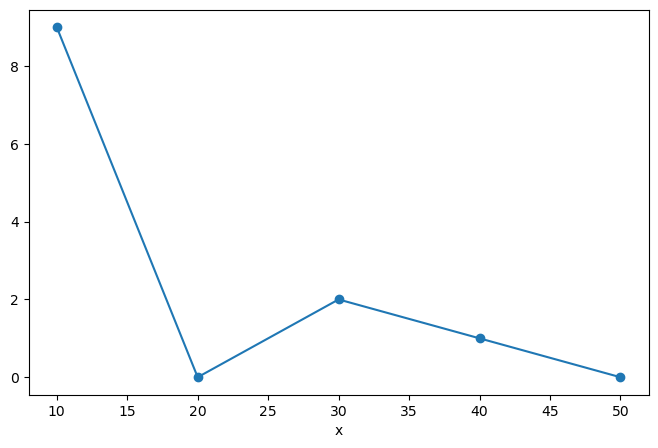

In [7]:
da.plot(marker='o')

### Multidimensional DataArray

If we are just dealing with 1D data, Pandas and Xarray have very similar capabilities. Xarray's real potential comes with multidimensional data.

Let's go back to the multidimensional ARGO data we loaded in the numpy lesson.

In [2]:
import pooch
url = "https://www.ldeo.columbia.edu/~rpa/float_data_4901412.zip"
files = pooch.retrieve(url, processor=pooch.Unzip(), known_hash="2a703c720302c682f1662181d329c9f22f9f10e1539dc2d6082160a469165009")
files.sort()
files

['/home/jovyan/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/P.npy',
 '/home/jovyan/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/S.npy',
 '/home/jovyan/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/T.npy',
 '/home/jovyan/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/date.npy',
 '/home/jovyan/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/lat.npy',
 '/home/jovyan/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/levels.npy',
 '/home/jovyan/.cache/pooch/7e6685dbe2a3c0b0870f770f3ef413d9-float_data_4901412.zip.unzip/float_data/lon.npy']

We will manually load each of these variables into a numpy array.
If this seems repetitive and inefficient, that's the point!
NumPy itself is not meant for managing groups of inter-related arrays.
That's what Xarray is for!

In [3]:
P = np.load(files[0])
S = np.load(files[1])
T = np.load(files[2])
date = np.load(files[3])
lat = np.load(files[4])
levels = np.load(files[5])
lon = np.load(files[6])

Let's organize the data and coordinates of the salinity variable into a DataArray.

In [9]:
da_salinity = xr.DataArray(S, dims=['level', 'date'],
                           coords={'level': levels,
                                   'date': date},)
da_salinity

<xarray.DataArray (level: 78, date: 75)> Size: 47kB
array([[35.6389389 , 35.51495743, 35.57297134, ..., 35.82093811,
        35.77793884, 35.66891098],
       [35.63393784, 35.5219574 , 35.57397079, ..., 35.81093216,
        35.58389664, 35.66791153],
       [35.6819458 , 35.52595901, 35.57297134, ..., 35.79592896,
        35.66290665, 35.66591263],
       ...,
       [34.91585922, 34.92390442, 34.92390442, ..., 34.93481064,
        34.94081116, 34.94680786],
       [34.91585922, 34.92390442, 34.92190552, ..., 34.93280792,
        34.93680954, 34.94380951],
       [34.91785812, 34.92390442, 34.92390442, ...,         nan,
        34.93680954,         nan]])
Coordinates:
  * level    (level) int64 624B 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 600B 2012-07-13T22:33:06.019200 ... 2014-0...

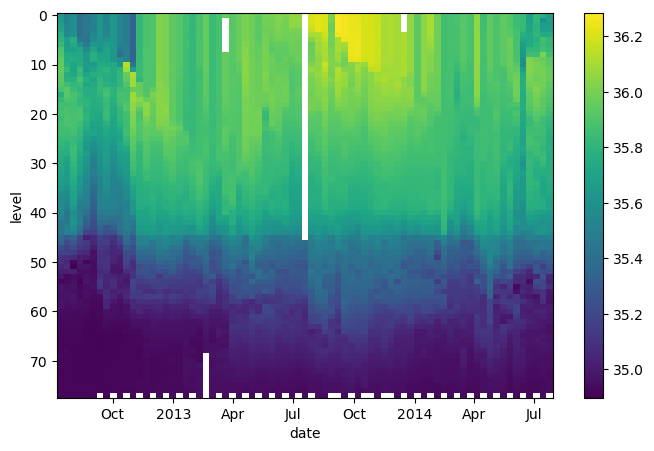

In [14]:
da_salinity.plot(yincrease=False)

Attributes can be used to store metadata. What metadata should you store? The [CF Conventions](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/cf-conventions.html#_description_of_the_data) are a great resource for thinking about climate metadata. Below we define two of the required CF-conventions attributes.

In [10]:
da_salinity.attrs['units'] = 'PSU'
da_salinity.attrs['standard_name'] = 'sea_water_salinity'
da_salinity

<xarray.DataArray (level: 78, date: 75)> Size: 47kB
array([[35.6389389 , 35.51495743, 35.57297134, ..., 35.82093811,
        35.77793884, 35.66891098],
       [35.63393784, 35.5219574 , 35.57397079, ..., 35.81093216,
        35.58389664, 35.66791153],
       [35.6819458 , 35.52595901, 35.57297134, ..., 35.79592896,
        35.66290665, 35.66591263],
       ...,
       [34.91585922, 34.92390442, 34.92390442, ..., 34.93481064,
        34.94081116, 34.94680786],
       [34.91585922, 34.92390442, 34.92190552, ..., 34.93280792,
        34.93680954, 34.94380951],
       [34.91785812, 34.92390442, 34.92390442, ...,         nan,
        34.93680954,         nan]])
Coordinates:
  * level    (level) int64 624B 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 600B 2012-07-13T22:33:06.019200 ... 2014-0...
Attributes:
    units:          PSU
    standard_name:  sea_water_salinity

Now if we plot the data again, the name and units are automatically attached to the figure.

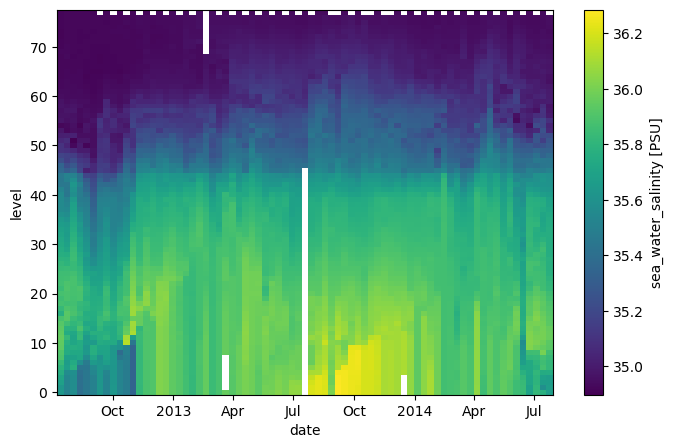

In [11]:
da_salinity.plot()

### Datasets

A Dataset holds many DataArrays which potentially can share coordinates. In analogy to pandas:

    pandas.Series : pandas.Dataframe :: xarray.DataArray : xarray.Dataset
    
Constructing Datasets manually is a bit more involved in terms of syntax. The Dataset constructor takes three arguments:

* `data_vars` should be a dictionary with each key as the name of the variable and each value as one of:
  * A `DataArray` or Variable
  * A tuple of the form `(dims, data[, attrs])`, which is converted into arguments for Variable
  * A pandas object, which is converted into a `DataArray`
  * A 1D array or list, which is interpreted as values for a one dimensional coordinate variable along the same dimension as it’s name
* `coords` should be a dictionary of the same form as data_vars.
* `attrs` should be a dictionary.

Let's put together a Dataset with temperature, salinity and pressure all together

In [12]:
argo = xr.Dataset(
    data_vars={
        'salinity':    (('level', 'date'), S),
        'temperature': (('level', 'date'), T),
        'pressure':    (('level', 'date'), P)
    },
    coords={
        'level': levels,
        'date': date
    }
)
argo

<xarray.Dataset> Size: 142kB
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 624B 0 1 2 3 4 5 6 7 ... 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 600B 2012-07-13T22:33:06.019200 ... 20...
Data variables:
    salinity     (level, date) float64 47kB 35.64 35.51 35.57 ... nan 34.94 nan
    temperature  (level, date) float64 47kB 18.97 18.44 19.1 ... nan 3.714 nan
    pressure     (level, date) float64 47kB 6.8 6.1 6.5 5.0 ... nan 2e+03 nan

What about lon and lat? We forgot them in the creation process, but we can add them after the fact.

In [13]:
argo.coords['lon'] = lon
argo

<xarray.Dataset> Size: 142kB
Dimensions:      (level: 78, date: 75, lon: 75)
Coordinates:
  * level        (level) int64 624B 0 1 2 3 4 5 6 7 ... 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 600B 2012-07-13T22:33:06.019200 ... 20...
  * lon          (lon) float64 600B -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
Data variables:
    salinity     (level, date) float64 47kB 35.64 35.51 35.57 ... nan 34.94 nan
    temperature  (level, date) float64 47kB 18.97 18.44 19.1 ... nan 3.714 nan
    pressure     (level, date) float64 47kB 6.8 6.1 6.5 5.0 ... nan 2e+03 nan

That was not quite right...we want lon to have dimension `date`:

In [14]:
del argo['lon']
argo.coords['lon'] = ('date', lon)
argo.coords['lat'] = ('date', lat)
argo

<xarray.Dataset> Size: 143kB
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 624B 0 1 2 3 4 5 6 7 ... 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 600B 2012-07-13T22:33:06.019200 ... 20...
    lon          (date) float64 600B -39.13 -37.28 -36.9 ... -34.11 -34.38
    lat          (date) float64 600B 47.19 46.72 46.45 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 47kB 35.64 35.51 35.57 ... nan 34.94 nan
    temperature  (level, date) float64 47kB 18.97 18.44 19.1 ... nan 3.714 nan
    pressure     (level, date) float64 47kB 6.8 6.1 6.5 5.0 ... nan 2e+03 nan

### Coordinates vs. Data Variables

Data variables can be modified through arithmentic operations or other functions. Coordinates are always keept the same.

In [15]:
argo * 10000

<xarray.Dataset> Size: 143kB
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 624B 0 1 2 3 4 5 6 7 ... 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 600B 2012-07-13T22:33:06.019200 ... 20...
    lon          (date) float64 600B -39.13 -37.28 -36.9 ... -34.11 -34.38
    lat          (date) float64 600B 47.19 46.72 46.45 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 47kB 3.564e+05 3.551e+05 ... nan
    temperature  (level, date) float64 47kB 1.897e+05 1.844e+05 ... nan
    pressure     (level, date) float64 47kB 6.8e+04 6.1e+04 ... 2e+07 nan

Clearly lon and lat are coordinates rather than data variables. We can change their status as follows:

In [16]:
argo = argo.set_coords(['lon', 'lat'])
argo

<xarray.Dataset> Size: 143kB
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 624B 0 1 2 3 4 5 6 7 ... 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 600B 2012-07-13T22:33:06.019200 ... 20...
    lon          (date) float64 600B -39.13 -37.28 -36.9 ... -34.11 -34.38
    lat          (date) float64 600B 47.19 46.72 46.45 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 47kB 35.64 35.51 35.57 ... nan 34.94 nan
    temperature  (level, date) float64 47kB 18.97 18.44 19.1 ... nan 3.714 nan
    pressure     (level, date) float64 47kB 6.8 6.1 6.5 5.0 ... nan 2e+03 nan

The `*` symbol in the representation above indicates that `level` and `date` are "dimension coordinates" (they describe the coordinates associated with data variable axes) while `lon` and `lat` are "non-dimension coordinates". We can make any variable a non-dimension coordiante.

Alternatively, we could have assigned directly to coords as follows:

In [17]:
argo.coords['lon'] = ('date', lon)
argo.coords['lat'] = ('date', lat)

## Selecting Data (Indexing)

We can always use regular numpy indexing and slicing on DataArrays

In [18]:
argo.salinity[2]

<xarray.DataArray 'salinity' (date: 75)> Size: 600B
array([35.6819458 , 35.52595901, 35.57297134, 35.40494537, 35.45091629,
       35.50192261, 35.62397766, 35.51696014, 35.62797546, 35.52292252,
       35.47383118, 35.33785629, 35.81896591, 35.88694   , 35.90187836,
       36.02391815, 36.00475693, 35.94187927, 35.91583252, 35.86392212,
       35.81995392, 35.88601303, 35.95079422, 35.84091568, 35.87992477,
               nan, 35.92179108, 35.96979141, 36.0008316 , 35.98083115,
       35.92887878, 35.98091888, 35.9838829 , 36.01884842, 35.99092484,
       36.04689026, 36.04185867,         nan, 36.19193268, 36.22789764,
       36.20986557, 35.97589874, 36.2779007 , 36.25889969, 36.2418251 ,
       36.23685837, 36.19781876, 36.19785309, 36.17692184, 36.1048851 ,
       36.11392212, 36.09080505,         nan, 36.05675888, 35.93374634,
       36.04291534, 36.10183716, 35.97779083, 35.86592102, 35.87791824,
       35.88392258, 35.92078781, 35.88601303, 36.05178833, 35.85883713,
       35.94878769, 35.8938446 , 35.94379425, 35.90884018, 35.84893036,
       35.83496857, 35.71691132, 35.79592896, 35.66290665, 35.66591263])
Coordinates:
    level    int64 8B 2
  * date     (date) datetime64[ns] 600B 2012-07-13T22:33:06.019200 ... 2014-0...
    lon      (date) float64 600B -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat      (date) float64 600B 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38

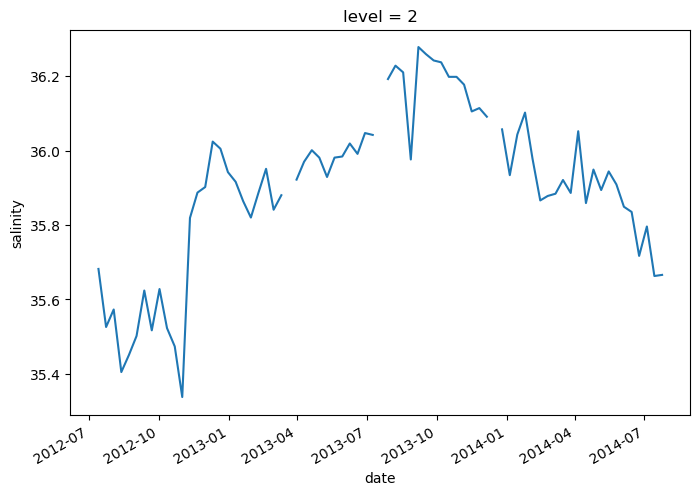

In [20]:
argo.salinity[2].plot()

In [21]:
argo.salinity[:, 10]

<xarray.DataArray 'salinity' (level: 78)>
array([35.47483063, 35.47483063, 35.47383118, 35.47383118, 35.47383118,
       35.47483063, 35.48183441, 35.47983551, 35.4948349 , 35.51083755,
       36.13380051, 36.09579849, 35.95479965, 35.93979645, 35.8958931 ,
       35.86388397, 35.87788773, 35.88188934, 35.90379333, 35.9067955 ,
       35.86588669, 35.8588829 , 35.86088181, 35.85188293, 35.85788345,
       35.82787323, 35.78786469, 35.73185349, 35.69784927, 35.67684174,
       35.677845  , 35.65784073, 35.64083481, 35.6238327 , 35.59682846,
       35.57782364, 35.56182098, 35.55781937, 35.52181625, 35.49881363,
       35.51381302, 35.49981308, 35.47280884, 35.47880936, 35.44780731,
       35.39379501, 35.35879135, 35.28778076, 35.21878052, 35.20677567,
       35.17777252, 35.15076828, 35.07276535, 35.01475525, 34.9797554 ,
       35.0117569 , 35.03975677, 35.05575562, 35.00975037, 34.96175385,
       34.96775055, 34.95075226, 34.93775177, 34.93375015, 34.93775558,
       34.9247551 , 34.92175674, 34.91975403, 34.91975403, 34.91975403,
       34.92176056, 34.92375946, 34.92575836, 34.92575836, 34.92475891,
       34.93076324, 34.92176437,         nan])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
    date     datetime64[ns] 2012-10-22T02:50:32.006400
    lon      float64 -32.97
    lat      float64 44.13

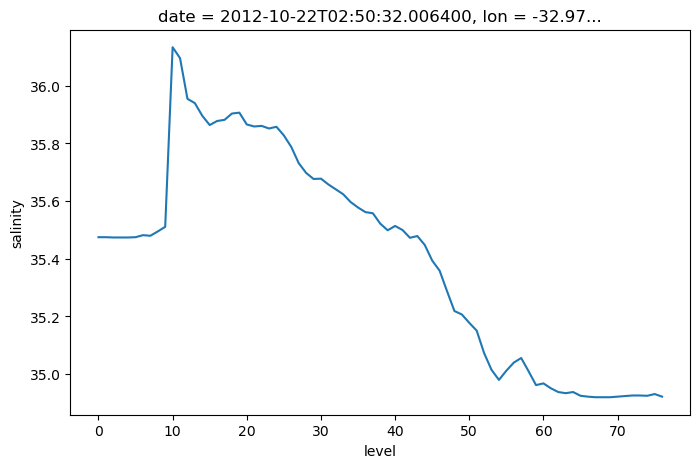

In [22]:
argo.salinity[:, 10].plot()

However, it is often much more powerful to use xarray's `.sel()` method to use label-based indexing.

In [23]:
argo.salinity.sel(level=2)

<xarray.DataArray 'salinity' (date: 75)>
array([35.6819458 , 35.52595901, 35.57297134, 35.40494537, 35.45091629,
       35.50192261, 35.62397766, 35.51696014, 35.62797546, 35.52292252,
       35.47383118, 35.33785629, 35.81896591, 35.88694   , 35.90187836,
       36.02391815, 36.00475693, 35.94187927, 35.91583252, 35.86392212,
       35.81995392, 35.88601303, 35.95079422, 35.84091568, 35.87992477,
               nan, 35.92179108, 35.96979141, 36.0008316 , 35.98083115,
       35.92887878, 35.98091888, 35.9838829 , 36.01884842, 35.99092484,
       36.04689026, 36.04185867,         nan, 36.19193268, 36.22789764,
       36.20986557, 35.97589874, 36.2779007 , 36.25889969, 36.2418251 ,
       36.23685837, 36.19781876, 36.19785309, 36.17692184, 36.1048851 ,
       36.11392212, 36.09080505,         nan, 36.05675888, 35.93374634,
       36.04291534, 36.10183716, 35.97779083, 35.86592102, 35.87791824,
       35.88392258, 35.92078781, 35.88601303, 36.05178833, 35.85883713,
       35.94878769, 35.8938446 , 35.94379425, 35.90884018, 35.84893036,
       35.83496857, 35.71691132, 35.79592896, 35.66290665, 35.66591263])
Coordinates:
    level    int64 2
  * date     (date) datetime64[ns] 2012-07-13T22:33:06.019200 ... 2014-07-24T...
    lon      (date) float64 -39.13 -37.28 -36.9 -36.89 ... -33.83 -34.11 -34.38
    lat      (date) float64 47.19 46.72 46.45 46.23 ... 42.72 42.6 42.46 42.38

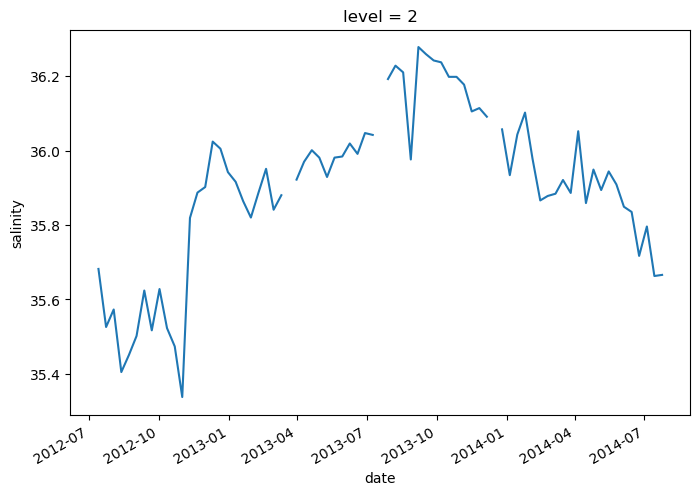

In [24]:
argo.salinity.sel(level=2).plot()

In [25]:
argo.salinity.sel(date='2012-10-22')

<xarray.DataArray 'salinity' (level: 78, date: 1)>
array([[35.47483063],
       [35.47483063],
       [35.47383118],
       [35.47383118],
       [35.47383118],
       [35.47483063],
       [35.48183441],
       [35.47983551],
       [35.4948349 ],
       [35.51083755],
       [36.13380051],
       [36.09579849],
       [35.95479965],
       [35.93979645],
       [35.8958931 ],
       [35.86388397],
       [35.87788773],
       [35.88188934],
       [35.90379333],
       [35.9067955 ],
...
       [35.00975037],
       [34.96175385],
       [34.96775055],
       [34.95075226],
       [34.93775177],
       [34.93375015],
       [34.93775558],
       [34.9247551 ],
       [34.92175674],
       [34.91975403],
       [34.91975403],
       [34.91975403],
       [34.92176056],
       [34.92375946],
       [34.92575836],
       [34.92575836],
       [34.92475891],
       [34.93076324],
       [34.92176437],
       [        nan]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 2012-10-22T02:50:32.006400
    lon      (date) float64 -32.97
    lat      (date) float64 44.13

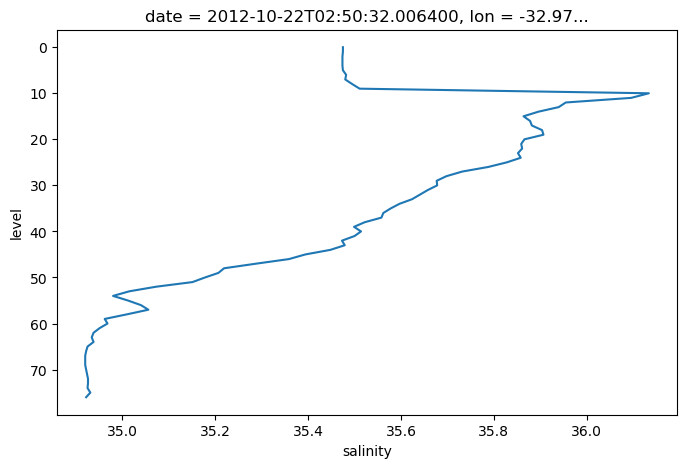

In [26]:
argo.salinity.sel(date='2012-10-22').plot(y='level', yincrease=False)

`.sel()` also supports slicing. Unfortunately we have to use a somewhat awkward syntax, but it still works.

In [27]:
argo.salinity.sel(date=slice('2012-10-01', '2012-12-01'))

<xarray.DataArray 'salinity' (level: 78, date: 7)>
array([[35.63097763, 35.52592468, 35.47483063, 35.33785629, 35.81896591,
        35.8889389 , 35.90187836],
       [35.63097763, 35.52292252, 35.47483063, 35.33685684, 35.81796646,
        35.88793945, 35.90187836],
       [35.62797546, 35.52292252, 35.47383118, 35.33785629, 35.81896591,
        35.88694   , 35.90187836],
       [35.62697601, 35.52192307, 35.47383118, 35.33785629, 35.81896591,
        35.89193726, 35.90187836],
       [35.62797546, 35.52192307, 35.47383118, 35.33785629, 35.81996536,
        35.88993835, 35.90187836],
       [35.62897873, 35.52292252, 35.47483063, 35.33785629, 35.81996536,
        35.88993835, 35.90187836],
       [35.62997818, 35.51892471, 35.48183441, 35.33785629, 35.81996536,
        35.88993835, 35.90187836],
       [35.63197708, 35.44991302, 35.47983551, 35.33785629, 35.81996536,
        35.89683914, 35.90187836],
       [35.63097763, 35.38090134, 35.4948349 , 35.33785629, 35.81896591,
        35.89583969, 35.90187836],
       [35.62697601, 35.58792114, 35.51083755, 35.33985519, 35.82497025,
        35.89683914, 35.90187836],
...
       [34.91690445, 34.92385483, 34.91975403, 34.91980362, 34.92385483,
        34.93680573, 34.93885422],
       [34.92190552, 34.92485428, 34.91975403, 34.92080688, 34.92485428,
        34.94480515, 34.9328537 ],
       [34.92390442, 34.92285538, 34.92176056, 34.92280579, 34.92985535,
        34.93280411, 34.92785645],
       [34.92390442, 34.92385483, 34.92375946, 34.92480469, 34.92685318,
        34.93780899, 34.92485428],
       [34.92390442, 34.92285538, 34.92575836, 34.92181015, 34.92085648,
        34.93680954, 34.92385483],
       [34.92590332, 34.9288559 , 34.92575836, 34.92181015, 34.92685318,
        34.93481064, 34.92585373],
       [34.92490387, 34.92785645, 34.92475891, 34.92781067, 34.93385696,
        34.93380737, 34.92385864],
       [34.92190552, 34.92385864, 34.93076324, 34.9268074 , 34.93585968,
        34.93481064, 34.92985916],
       [34.92090607, 34.92185974, 34.92176437, 34.9228096 , 34.93285751,
        34.93180847, 34.92786026],
       [        nan, 34.91985703,         nan, 34.92181015,         nan,
        34.92181015,         nan]])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 2012-10-02T03:00:17.971200 ... 2012-12-01T...
    lon      (date) float64 -34.46 -33.78 -32.97 -32.55 -32.43 -32.29 -32.17
    lat      (date) float64 44.96 44.68 44.13 43.64 43.07 42.66 42.51

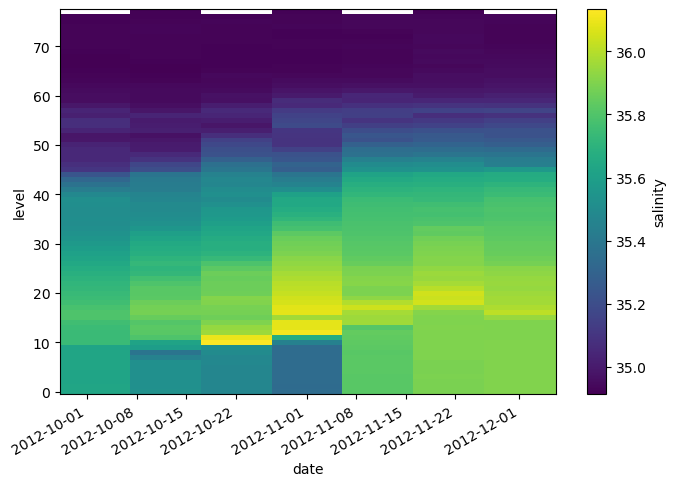

In [28]:
argo.salinity.sel(date=slice('2012-10-01', '2012-12-01')).plot()

`.sel()` also works on the whole Dataset

In [29]:
argo.sel(date='2012-10-22')

<xarray.Dataset>
Dimensions:      (level: 78, date: 1)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 2012-10-22T02:50:32.006400
    lon          (date) float64 -32.97
    lat          (date) float64 44.13
Data variables:
    salinity     (level, date) float64 35.47 35.47 35.47 ... 34.93 34.92 nan
    temperature  (level, date) float64 17.13 17.13 17.13 ... 3.736 3.639 nan
    pressure     (level, date) float64 6.4 10.3 15.4 ... 1.9e+03 1.951e+03 nan

## Computation

Xarray dataarrays and datasets work seamlessly with arithmetic operators and numpy array functions.

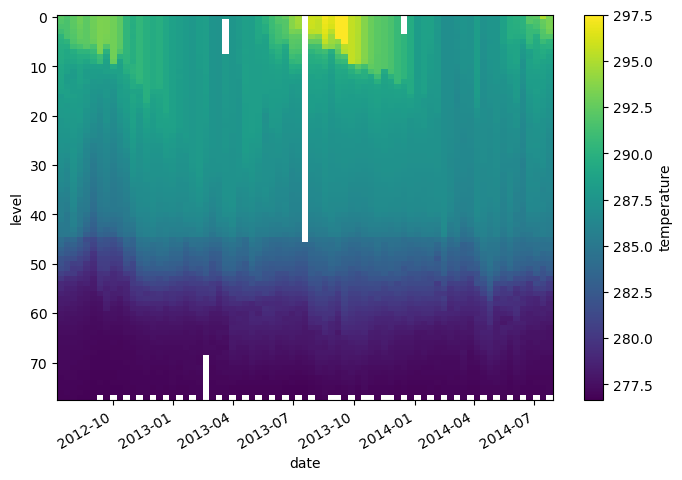

In [30]:
temp_kelvin = argo.temperature + 273.15
temp_kelvin.plot(yincrease=False)

We can also combine multiple xarray datasets in arithemtic operations

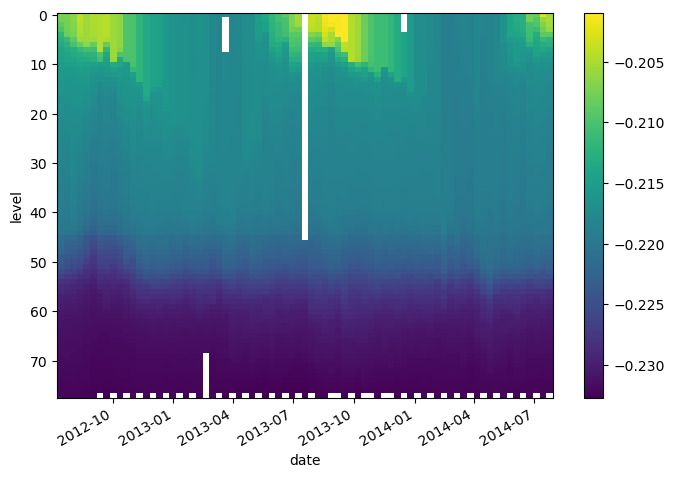

In [31]:
g = 9.8
buoyancy = g * (2e-4 * argo.temperature - 7e-4 * argo.salinity)
buoyancy.plot(yincrease=False)

## Broadcasting, Aligment, and Combining Data

### Broadcasting

Broadcasting arrays in numpy is a nightmare. It is much easier when the data axes are labeled!

This is a useless calculation, but it illustrates how perfoming an operation on arrays with differenty coordinates will result in automatic broadcasting

In [22]:
level_times_lat = argo.level * argo.lat
level_times_lat

<xarray.DataArray (level: 78, date: 75)> Size: 47kB
array([[   0.   ,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       [  47.187,   46.716,   46.45 , ...,   42.601,   42.457,   42.379],
       [  94.374,   93.432,   92.9  , ...,   85.202,   84.914,   84.758],
       ...,
       [3539.025, 3503.7  , 3483.75 , ..., 3195.075, 3184.275, 3178.425],
       [3586.212, 3550.416, 3530.2  , ..., 3237.676, 3226.732, 3220.804],
       [3633.399, 3597.132, 3576.65 , ..., 3280.277, 3269.189, 3263.183]])
Coordinates:
  * level    (level) int64 624B 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
  * date     (date) datetime64[ns] 600B 2012-07-13T22:33:06.019200 ... 2014-0...
    lon      (date) float64 600B -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat      (date) float64 600B 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38

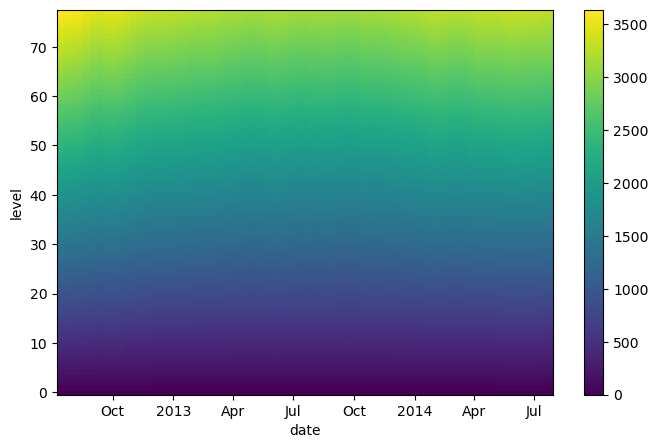

In [23]:
level_times_lat.plot()

### Alignment

If you try to perform operations on DataArrays that share a dimension name, Xarray will try to _align_ them first.
This works nearly identically to Pandas, except that there can be multiple dimensions to align over.

To see how alignment works, we will create some subsets of our original data.

In [24]:
sa_surf = argo.salinity.isel(level=slice(0, 20))
sa_mid = argo.salinity.isel(level=slice(10, 30))

By default, when we combine multiple arrays in mathematical operations, Xarray performs an "inner join".

In [25]:
(sa_surf * sa_mid).level

<xarray.DataArray 'level' (level: 10)> Size: 80B
array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
Coordinates:
  * level    (level) int64 80B 10 11 12 13 14 15 16 17 18 19

We can override this behavior by manually aligning the data

In [28]:
sa_surf_outer, sa_mid_outer = xr.align(sa_surf, sa_mid, join='outer')
sa_surf_outer.level
# sa_mid_outer.level

<xarray.DataArray 'level' (level: 30)> Size: 240B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
Coordinates:
  * level    (level) int64 240B 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29

As we can see, missing data (NaNs) have been filled in where the array was extended.

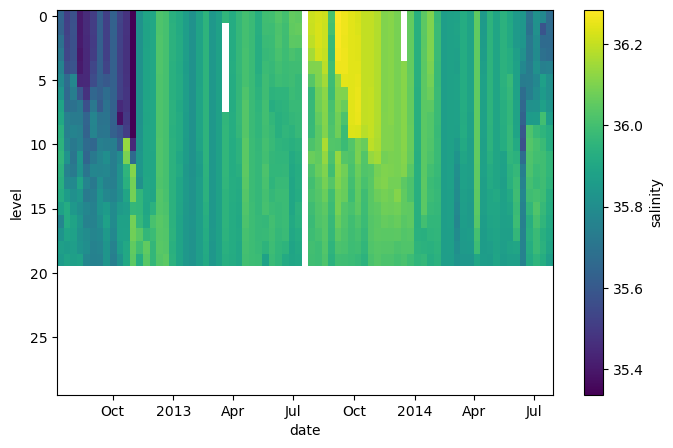

In [31]:
sa_surf_outer.plot(yincrease=False)

We can also use `join='right'` and `join='left'`.

### Combing Data: Concat and Merge

The ability to combine many smaller arrays into a single big Dataset is one of the main advantages of Xarray.
To take advantage of this, we need to learn two operations that help us combine data:
- `xr.contact`: to concatenate multiple arrays into one bigger array along their dimensions
- `xr.merge`: to combine multiple different arrays into a dataset

First let's look at concat. Let's re-combine the subsetted data from the previous step.

In [32]:
sa_surf_mid = xr.concat([sa_surf, sa_mid], dim='level')
sa_surf_mid

<xarray.DataArray 'salinity' (level: 40, date: 75)> Size: 24kB
array([[35.6389389 , 35.51495743, 35.57297134, ..., 35.82093811,
        35.77793884, 35.66891098],
       [35.63393784, 35.5219574 , 35.57397079, ..., 35.81093216,
        35.58389664, 35.66791153],
       [35.6819458 , 35.52595901, 35.57297134, ..., 35.79592896,
        35.66290665, 35.66591263],
       ...,
       [35.78895187, 35.7829895 , 35.85100555, ..., 35.84291458,
        35.81891251, 35.7779007 ],
       [35.76794815, 35.75598526, 35.84500504, ..., 35.84891891,
        35.83391571, 35.76390076],
       [35.75194168, 35.71097565, 35.83100128, ..., 35.80690765,
        35.85292053, 35.75489807]])
Coordinates:
  * level    (level) int64 320B 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29
  * date     (date) datetime64[ns] 600B 2012-07-13T22:33:06.019200 ... 2014-0...
    lon      (date) float64 600B -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat      (date) float64 600B 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38

```{warning}
Xarray won't check the values of the coordinates before `concat`. It will just stick everything together into a new array.
```

In this case, we had overlapping data. We can see this by looking at the `level` coordinate.

In [33]:
sa_surf_mid.level

<xarray.DataArray 'level' (level: 40)> Size: 320B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29])
Coordinates:
  * level    (level) int64 320B 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29

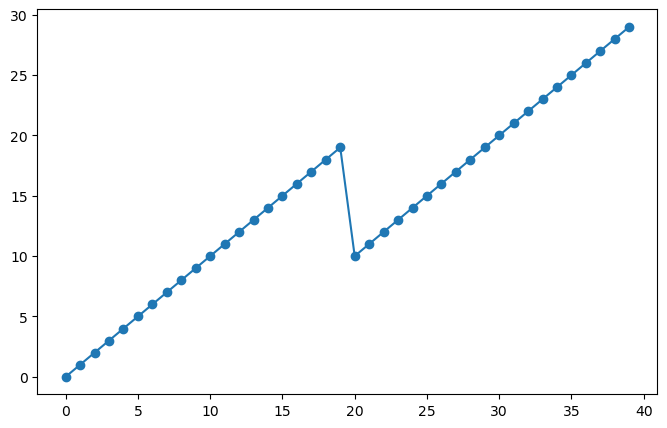

In [34]:
plt.plot(sa_surf_mid.level.values, marker='o')

We can also concat data along a _new_ dimension, e.g.

In [41]:
sa_concat_new = xr.concat([sa_surf, sa_mid], dim='newdim')
sa_concat_new

# sa_concat_new[0,:,:].plot()

<xarray.DataArray 'salinity' (newdim: 2, level: 30, date: 75)> Size: 36kB
array([[[35.6389389 , 35.51495743, 35.57297134, ..., 35.82093811,
         35.77793884, 35.66891098],
        [35.63393784, 35.5219574 , 35.57397079, ..., 35.81093216,
         35.58389664, 35.66791153],
        [35.6819458 , 35.52595901, 35.57297134, ..., 35.79592896,
         35.66290665, 35.66591263],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [35.78895187, 35.7829895 , 35.85100555, ..., 35.84291458,
         35.81891251, 35.7779007 ],
        [35.76794815, 35.75598526, 35.84500504, ..., 35.84891891,
         35.83391571, 35.76390076],
        [35.75194168, 35.71097565, 35.83100128, ..., 35.80690765,
         35.85292053, 35.75489807]]])
Coordinates:
  * level    (level) int64 240B 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29
  * date     (date) datetime64[ns] 600B 2012-07-13T22:33:06.019200 ... 2014-0...
    lon      (date) float64 600B -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat      (date) float64 600B 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38
Dimensions without coordinates: newdim

Note that the data were aligned using an _outer_ join along the non-concat dimensions.

Instead of specifying a new dimension name, we can pass a new Pandas index object explicitly to `concat`.
This will create a new dimension coordinate and corresponding index.

We can merge both DataArrays and Datasets.

In [42]:
xr.merge([argo.salinity, argo.temperature])

<xarray.Dataset> Size: 96kB
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 624B 0 1 2 3 4 5 6 7 ... 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 600B 2012-07-13T22:33:06.019200 ... 20...
    lon          (date) float64 600B -39.13 -37.28 -36.9 ... -34.11 -34.38
    lat          (date) float64 600B 47.19 46.72 46.45 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 47kB 35.64 35.51 35.57 ... nan 34.94 nan
    temperature  (level, date) float64 47kB 18.97 18.44 19.1 ... nan 3.714 nan

If the data are not aligned, they will be aligned before merge.
We can specify the join options in `merge`.

In [43]:
xr.merge([
    argo.salinity.sel(level=slice(0, 30)),
    argo.temperature.sel(level=slice(30, None))
])

<xarray.Dataset> Size: 96kB
Dimensions:      (level: 78, date: 75)
Coordinates:
  * level        (level) int64 624B 0 1 2 3 4 5 6 7 ... 70 71 72 73 74 75 76 77
  * date         (date) datetime64[ns] 600B 2012-07-13T22:33:06.019200 ... 20...
    lon          (date) float64 600B -39.13 -37.28 -36.9 ... -34.11 -34.38
    lat          (date) float64 600B 47.19 46.72 46.45 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 47kB 35.64 35.51 35.57 ... nan nan nan
    temperature  (level, date) float64 47kB nan nan nan nan ... nan 3.714 nan

In [44]:
xr.merge([
    argo.salinity.sel(level=slice(0, 30)),
    argo.temperature.sel(level=slice(30, None))
], join='left')

<xarray.Dataset> Size: 39kB
Dimensions:      (level: 31, date: 75)
Coordinates:
  * level        (level) int64 248B 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29 30
  * date         (date) datetime64[ns] 600B 2012-07-13T22:33:06.019200 ... 20...
    lon          (date) float64 600B -39.13 -37.28 -36.9 ... -34.11 -34.38
    lat          (date) float64 600B 47.19 46.72 46.45 ... 42.6 42.46 42.38
Data variables:
    salinity     (level, date) float64 19kB 35.64 35.51 35.57 ... 35.83 35.76
    temperature  (level, date) float64 19kB nan nan nan ... 13.59 13.74 13.31

## Reductions

Just like in numpy, we can reduce xarray DataArrays along any number of axes:

In [45]:
argo.temperature.mean(axis=0)

<xarray.DataArray 'temperature' (date: 75)> Size: 600B
array([10.88915385, 10.7282564 , 10.9336282 , 10.75679484, 10.38166666,
       10.08619236, 10.58194804, 10.50066671, 10.56841555, 10.53705122,
       10.81131168, 11.01932052, 11.39205196, 11.40823073, 11.3642208 ,
       11.35821797, 11.39444157, 11.10514098, 11.02870125, 10.80894868,
       10.93076625, 11.01069231, 11.88195654, 10.57373078, 10.66359736,
       10.56573237, 11.08854546, 10.87921792, 11.21384416, 11.24991028,
       11.29168825, 11.06203848, 11.32829864, 11.20401279, 11.25300001,
       11.32106403, 11.40112986,  6.07053117, 11.7748052 , 11.7466795 ,
       12.03732056, 11.92653251, 12.08844156, 12.20543591, 12.23402598,
       12.03365387, 11.9919221 , 11.92087012, 11.84273071, 11.79711684,
       11.7895325 , 11.55385894, 11.19083561, 11.266282  , 11.0611948 ,
       11.0307179 , 11.06566232, 10.79799995, 10.787     , 10.41173077,
       10.44170127, 10.32649998, 10.38242857, 10.88080769, 10.86177921,
       10.98787178, 10.93602596, 10.73039743, 11.09251948, 10.93983334,
       10.65942862, 11.01814097, 11.21918184, 11.19080765, 11.13364934])
Coordinates:
  * date     (date) datetime64[ns] 600B 2012-07-13T22:33:06.019200 ... 2014-0...
    lon      (date) float64 600B -39.13 -37.28 -36.9 ... -33.83 -34.11 -34.38
    lat      (date) float64 600B 47.19 46.72 46.45 46.23 ... 42.6 42.46 42.38

In [46]:
argo.temperature.mean(axis=1)

<xarray.DataArray 'temperature' (level: 78)>
array([17.60172602, 17.57223609, 17.5145833 , 17.42326395, 17.24943838,
       17.03730134, 16.76787661, 16.44609588, 16.17439195, 16.04501356,
       15.65827023, 15.4607296 , 15.26114862, 15.12489191, 14.99133783,
       14.90160808, 14.81990544, 14.74535139, 14.66822971, 14.585027  ,
       14.49732434, 14.41904053, 14.35412163, 14.27102702, 14.19081082,
       14.11487838, 14.04347293, 13.98067566, 13.90994595, 13.83274319,
       13.76139196, 13.69836479, 13.62335132, 13.54185131, 13.46647295,
       13.39395946, 13.32541891, 13.25205403, 13.18131082, 13.10233782,
       12.89268916, 12.67795943, 12.4649189 , 12.2178513 , 11.98270268,
       11.1281081 , 10.80430666, 10.49702667, 10.1749066 ,  9.83453334,
        9.48625332,  9.19793334,  8.66010666,  8.12324001,  7.60221333,
        7.15289333,  6.74250667,  6.39543999,  6.04598667,  5.74538665,
        5.48913333,  5.26604001,  5.08768   ,  4.93479998,  4.77769334,
        4.65368   ,  4.54237334,  4.44274664,  4.35933333,  4.2653784 ,
        4.17290539,  4.08902703,  3.99864865,  3.92163514,  3.85617567,
        3.78916217,  3.72950001,  3.66207691])
Coordinates:
  * level    (level) int64 0 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75 76 77

However, rather than performing reductions on axes (as in numpy), we can perform them on dimensions. This turns out to be a huge convenience

In [47]:
argo_mean = argo.mean(dim='date')
argo_mean

<xarray.Dataset>
Dimensions:      (level: 78)
Coordinates:
  * level        (level) int64 0 1 2 3 4 5 6 7 8 ... 69 70 71 72 73 74 75 76 77
Data variables:
    salinity     (level) float64 35.91 35.9 35.9 35.9 ... 34.94 34.94 34.93
    temperature  (level) float64 17.6 17.57 17.51 17.42 ... 3.789 3.73 3.662
    pressure     (level) float64 6.435 10.57 15.54 ... 1.95e+03 1.999e+03

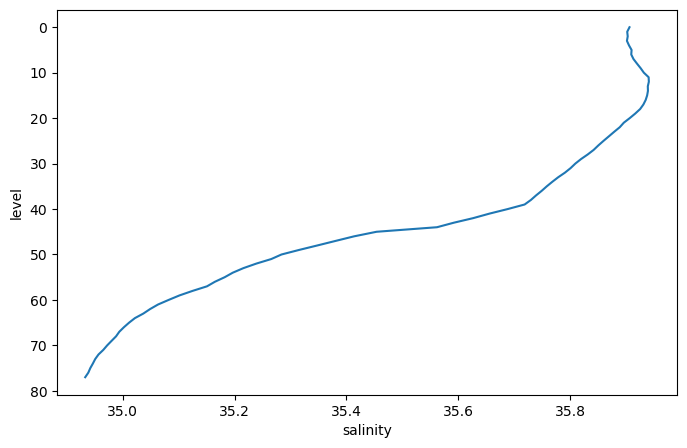

In [48]:
argo_mean.salinity.plot(y='level', yincrease=False)

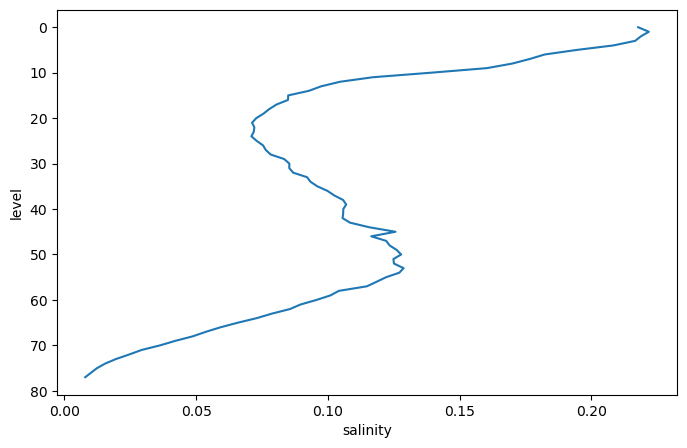

In [49]:
argo_std = argo.std(dim='date')
argo_std.salinity.plot(y='level', yincrease=False)

### Weighted Reductions

Sometimes we want to perform a reduction (e.g. a mean) where we assign different weight factors to each point in the array.
Xarray supports this via [weighted array reductions](http://xarray.pydata.org/en/stable/user-guide/computation.html#weighted-array-reductions).

As a toy example, imagine we want to weight values in the upper ocean more than the lower ocean.
We could imagine creating a weight array exponentially proportional to pressure as follows:

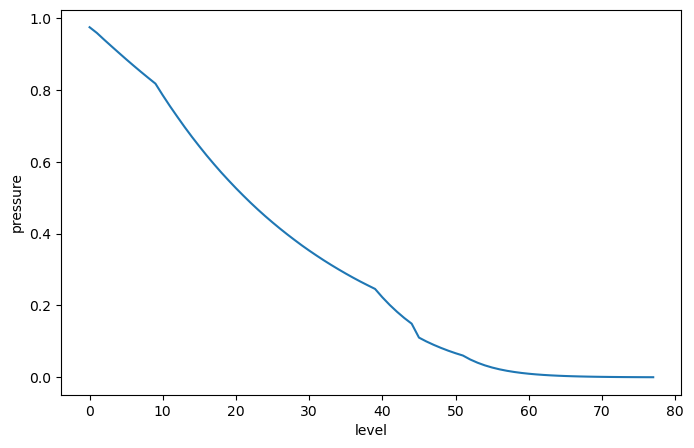

In [50]:
mean_pressure = argo.pressure.mean(dim='date')
p0 = 250  # dbat
weights = np.exp(-mean_pressure / p0)
weights.plot()

The weighted mean over the `level` dimensions is calculated as follows:

In [51]:
temp_weighted_mean = argo.temperature.weighted(weights).mean('level')

Comparing to the unweighted mean, we see the difference:

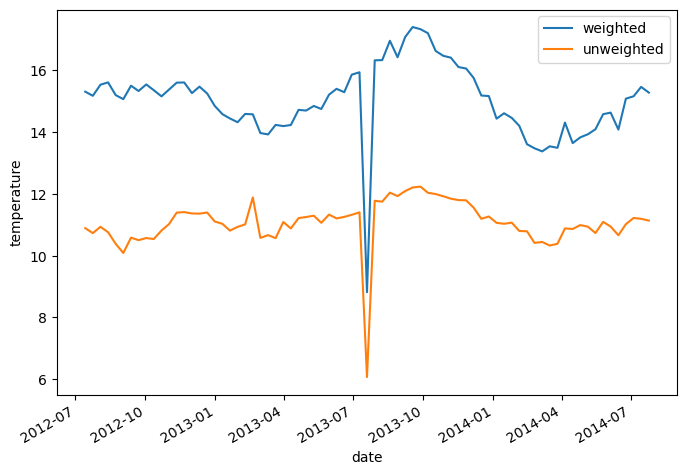

In [52]:
temp_weighted_mean.plot(label='weighted')
argo.temperature.mean(dim='level').plot(label='unweighted')
plt.legend()

## Loading Data from netCDF Files

NetCDF (Network Common Data Format) is the most widely used format for distributing geoscience data. NetCDF is maintained by the [Unidata](https://www.unidata.ucar.edu/) organization.

Below we quote from the [NetCDF website](https://www.unidata.ucar.edu/software/netcdf/docs/faq.html#whatisit):

>NetCDF (network Common Data Form) is a set of interfaces for array-oriented data access and a freely distributed collection of data access libraries for C, Fortran, C++, Java, and other languages. The netCDF libraries support a machine-independent format for representing scientific data. Together, the interfaces, libraries, and format support the creation, access, and sharing of scientific data.
>
>NetCDF data is:
>
> - Self-Describing. A netCDF file includes information about the data it contains.
> - Portable. A netCDF file can be accessed by computers with different ways of storing integers, characters, and floating-point numbers.
> - Scalable. A small subset of a large dataset may be accessed efficiently.
> - Appendable. Data may be appended to a properly structured netCDF file without copying the dataset or redefining its structure.
> - Sharable. One writer and multiple readers may simultaneously access the same netCDF file.
> - Archivable. Access to all earlier forms of netCDF data will be supported by current and future versions of the software.

Xarray was designed to make reading netCDF files in python as easy, powerful, and flexible as possible. (See [xarray netCDF docs](http://xarray.pydata.org/en/latest/io.html#netcdf) for more details.)

Below we download and load some the NASA [GISSTemp](https://data.giss.nasa.gov/gistemp/) global temperature anomaly dataset.

In [47]:
## doesn't work anymore... Forbidden for url: https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz
# gistemp_file = pooch.retrieve(
#     'https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz',
#     known_hash='2a703c720302c682f1662181d329c9f22f9f10e1539dc2d6082160a469165009',
#     processor=pooch.Decompress(),
# )

## netcdf file has been downloaded to data/ directory 
gistemp_file = 'data/gistemp1200_GHCNv4_ERSSTv5.nc'

In [48]:
ds = xr.open_dataset(gistemp_file)
ds

<xarray.Dataset> Size: 112MB
Dimensions:      (lat: 90, lon: 180, time: 1735, nv: 2)
Coordinates:
  * lat          (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon          (lon) float32 720B -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 14kB 1880-01-15 1880-02-15 ... 2024-07-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 28kB ...
    tempanomaly  (time, lat, lon) float32 112MB ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2024-08-07 14:09:14 by SBBX_to_nc 2.0 - ILAND=1200,...

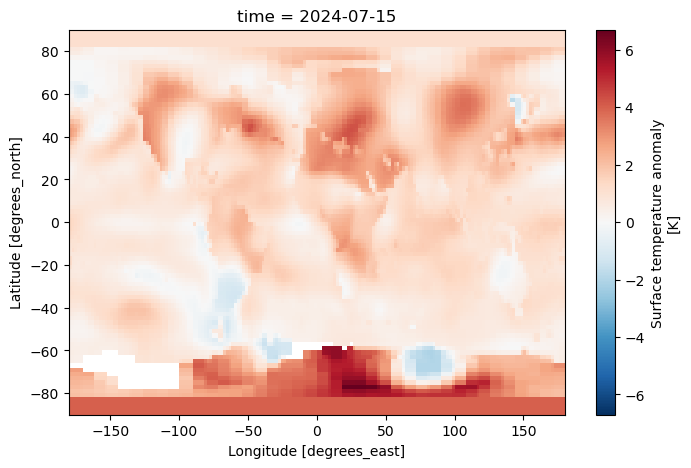

In [51]:
ds.tempanomaly.isel(time=-1).plot()

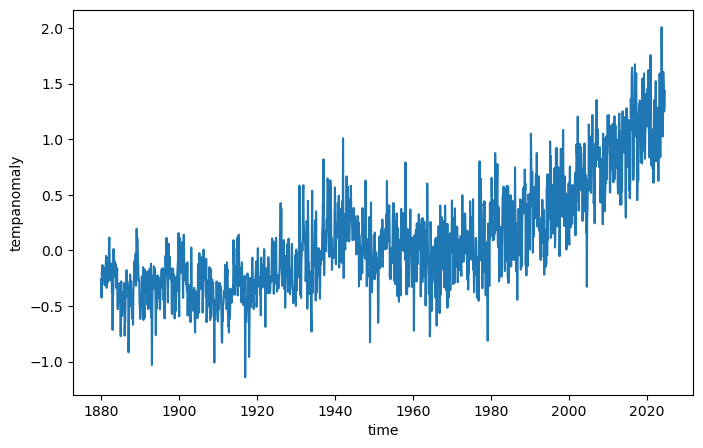

In [52]:
ds.tempanomaly.mean(dim=('lon', 'lat')).plot()